In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/fall25-ece460j-kaggle-competition/sample_submission.csv
/kaggle/input/fall25-ece460j-kaggle-competition/train.csv
/kaggle/input/fall25-ece460j-kaggle-competition/test.csv


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from scipy.stats import skew

import sklearn
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV 
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler 
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier

%config InlineBackend.figure_format = 'png'
%matplotlib inline

## Reading in Data 
First looks at the data and organizing them into train and test parts. We are able to see the original sizes of the datasets and prepare them for the rest of the preprocessing. 

In [3]:
train = pd.read_csv("/kaggle/input/fall25-ece460j-kaggle-competition/train.csv")
test = pd.read_csv("/kaggle/input/fall25-ece460j-kaggle-competition/test.csv")

test.head()

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries
0,15000,45.0,165.0,70.0,81.0,1.2,1.2,1.0,1.0,118.0,...,114.0,56.0,107.0,15.5,1.0,0.9,20.0,32.0,44.0,1.0
1,15001,45.0,160.0,50.0,71.0,0.8,0.8,1.0,1.0,100.0,...,49.0,75.0,130.0,13.9,1.0,1.0,27.0,20.0,25.0,0.0
2,15002,45.0,160.0,70.0,88.0,1.0,1.0,1.0,1.0,134.0,...,101.0,50.0,95.0,15.3,1.0,0.7,25.0,23.0,29.0,0.0
3,15003,40.0,165.0,60.0,72.0,1.0,1.2,1.0,1.0,109.0,...,66.0,74.0,101.0,13.6,1.0,0.7,18.0,12.0,14.0,0.0
4,15004,35.0,170.0,70.0,81.0,1.0,1.2,1.0,1.0,112.0,...,56.0,58.0,117.0,14.8,1.0,1.0,24.0,25.0,24.0,0.0


In [4]:
print("Train shape:", train.shape, "Test shape:", test.shape)

Train shape: (15000, 24) Test shape: (10000, 23)


In [5]:
train_noid = train.drop('id', axis=1)
test_noid = test.drop('id', axis=1)

In [6]:
all_data = pd.concat((train.loc[:,'age':'dental caries'],test.loc[:,'age':'dental caries']))

In [7]:
all_data.head()

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries
0,50.0,160.0,60.0,77.0,0.8,0.7,1.0,1.0,105.0,63.0,...,64.0,50.0,117.0,13.9,1.0,0.7,16.0,13.0,15.0,0.0
1,30.0,180.0,70.0,82.0,1.2,1.2,1.0,1.0,115.0,79.0,...,66.0,67.0,87.0,14.7,1.0,0.9,18.0,19.0,22.0,0.0
2,45.0,170.0,70.0,82.0,1.5,1.2,1.0,1.0,124.0,81.0,...,123.0,50.0,78.0,12.7,1.0,1.1,16.0,13.0,33.0,0.0
3,60.0,150.0,50.0,77.0,0.7,1.0,1.0,1.0,104.0,68.0,...,142.0,48.0,87.0,13.1,1.0,0.8,17.0,12.0,14.0,0.0
4,45.0,155.0,55.0,73.0,1.5,1.5,1.0,1.0,123.0,79.0,...,87.0,72.0,91.0,14.4,1.0,0.6,24.0,19.0,22.0,0.0


In [8]:
scaler = StandardScaler()

X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.smoking

## Visualization 

In [9]:
print(f"Number of null values in X_train: {np.isnan(X_train).sum()}")
print(f"Number of Dimensions: {X_train.ndim}")
print(f"Shape: {X_train.shape}")

Number of null values in X_train: age                    0
height(cm)             0
weight(kg)             0
waist(cm)              0
eyesight(left)         0
eyesight(right)        0
hearing(left)          0
hearing(right)         0
systolic               0
relaxation             0
fasting blood sugar    0
Cholesterol            0
triglyceride           0
HDL                    0
LDL                    0
hemoglobin             0
Urine protein          0
serum creatinine       0
AST                    0
ALT                    0
Gtp                    0
dental caries          0
dtype: int64
Number of Dimensions: 2
Shape: (15000, 22)


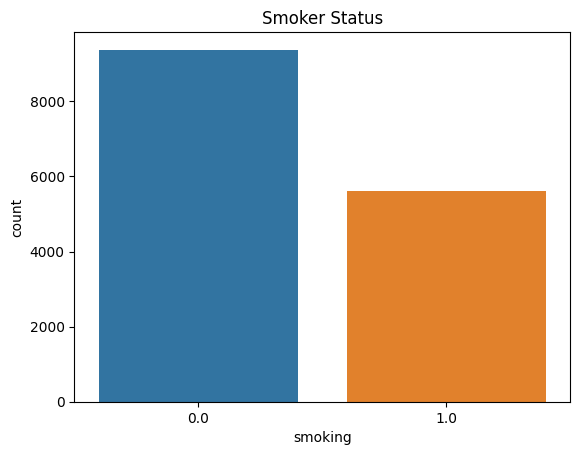

In [10]:
# Visualization of current distribution in the training data 
plt.figure()
sns.countplot(x=y)
plt.title('Smoker Status')
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


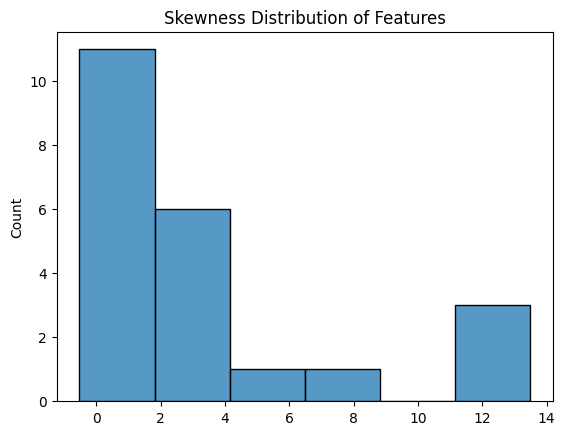

In [11]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna()))
sns.histplot(skewed_feats)
plt.title("Skewness Distribution of Features")
plt.show()

skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

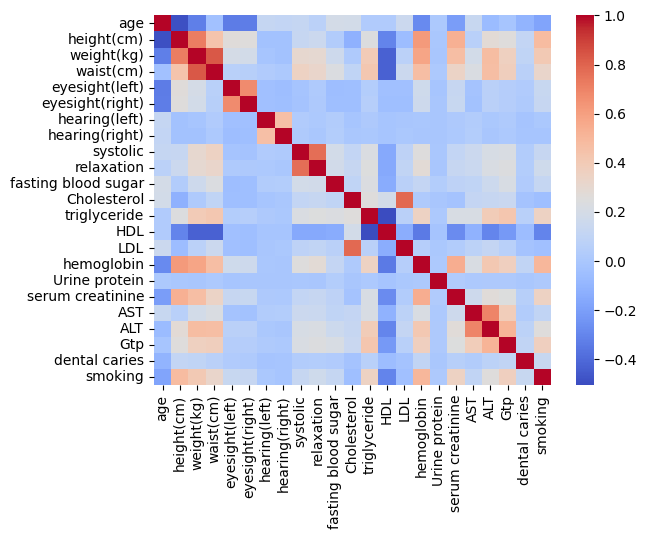

Top 5 Correlated with Smoker Status
hemoglobin          0.504360
height(cm)          0.476851
weight(kg)          0.409750
Gtp                 0.366762
serum creatinine    0.350503
Name: smoking, dtype: float64


In [12]:
train_corr = X_train.copy()
train_corr['smoking'] = y

plt.figure()
correlation_matrix = train_corr.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f")
plt.show()

target_corr = correlation_matrix['smoking'].sort_values(ascending=False)
print("Top 5 Correlated with Smoker Status")
print(target_corr.drop('smoking').head(5))

## Feature Engineering

In [13]:
def feature_engineer(df):
    df_fe = df.copy()
    # Creating Interaction Terms ~ 
    df_fe['BMI'] = (df_fe['weight(kg)']) / ((df_fe['height(cm)']/100)**2)
    df_fe['cholesterol_ratio'] = df_fe['LDL'] / df_fe['HDL'] 

    return df_fe

X_train_fe = feature_engineer(X_train)
X_test_fe = feature_engineer(X_test)

## Training Models

In [14]:
X_train_fe = scaler.fit_transform(X_train_fe)
X_test_fe = scaler.transform(X_test_fe)
scoring_metric = 'roc_auc'

### Logistic Regression

In [15]:
log_reg = LogisticRegression(multi_class='multinomial', solver='saga', max_iter=100, tol=0.1)
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(log_reg, param_grid, cv=10, n_jobs=-1, verbose=2)
grid_search.fit(X_train_fe, y)

best_log_reg = grid_search.best_estimator_
y_train_pred = best_log_reg.predict(X_train_fe)
y_test_pred = best_log_reg.predict(X_test_fe)

train_accuracy = accuracy_score(y, y_train_pred)

print(f"Training Accuracy: {train_accuracy}")
print(f"Best LR: {grid_search.best_score_:.4f}")
print(f"Best parameters: {grid_search.best_params_}")

#Also trying logistic regression model with l1 penalty, slightly worse training accuracy results, but AUC is better. 
log_reg_l1 = LogisticRegression(multi_class='multinomial', max_iter=100, tol=0.1, penalty='l1', solver='saga')

param_grid_l1 = {'C': [0.01, 0.1, 1, 10, 100]}
grid_search_l1 = GridSearchCV(log_reg_l1, param_grid_l1, cv=3, n_jobs=-1, verbose=2)
grid_search_l1.fit(X_train_fe, y)

best_log_reg_l1 = grid_search_l1.best_estimator_
y_train_pred_l1 = best_log_reg_l1.predict(X_train_fe)
y_test_pred_l1 = best_log_reg_l1.predict(X_test_fe)

train_accuracy_l1 = accuracy_score(y, y_train_pred_l1)
print(f"Best LR L1 AUC: {grid_search_l1.best_score_:.4f}")
print(f"Best parameters: {grid_search_l1.best_params_}")
print(f"L1 Regularized Training Accuracy: {train_accuracy_l1}")


Fitting 10 folds for each of 5 candidates, totalling 50 fits
Training Accuracy: 0.7789333333333334
Best LR: 0.7776
Best parameters: {'C': 0.1}
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best LR L1 AUC: 0.7782
Best parameters: {'C': 1}
L1 Regularized Training Accuracy: 0.7791333333333333


## Random Forest

In [16]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=10, scoring='roc_auc',n_jobs=-1, verbose=1)
grid_search.fit(X_train_fe, y)

best_rf_classifier = grid_search.best_estimator_
y_pred = best_rf_classifier.predict(X_test_fe)

print(f"Best Random Forest AUC: {grid_search.best_score_:.4f}")
print(f"Best Hyperparameters: {grid_search.best_params_}")

Fitting 10 folds for each of 12 candidates, totalling 120 fits
Best Random Forest AUC: 0.8841
Best Hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}


## XGBoost 

In [17]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', seed=42)

param_grid = {
    'n_estimators': [500, 1000, 1500],
    'learning_rate': [0.05, 0.01, 0.1],
    'max_depth': [3, 5, None],
    'subsample': [0.7, 0.9], 
    'colsample_bytree': [0.7]
}

xgb_grid = GridSearchCV(xgb_model, param_grid, cv=10, scoring='roc_auc')
xgb_grid.fit(X_train_fe, y)
print("Fitting xgb")

best_xgb_model = xgb_grid.best_estimator_
print(f"Best XGB AUC: {xgb_grid.best_score_:.4f}")
print(f"Best Hyperparameters: {xgb_grid.best_params_}")

[CV] END .............................................C=0.01; total time=   0.0s
[CV] END .............................................C=0.01; total time=   0.1s
[CV] END ..............................................C=0.1; total time=   0.0s
[CV] END ..............................................C=0.1; total time=   0.0s
[CV] END ..............................................C=0.1; total time=   0.0s
[CV] END ................................................C=1; total time=   0.0s
[CV] END ................................................C=1; total time=   0.0s
[CV] END ................................................C=1; total time=   0.1s
[CV] END ...............................................C=10; total time=   0.1s
[CV] END ...............................................C=10; total time=   0.1s
[CV] END ..............................................C=100; total time=   0.1s
[CV] END ..............................................C=100; total time=   0.1s
[CV] END ...................

In [18]:
xgb_model_nofe = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', seed=42)

param_grid_nofe = {
    'n_estimators': [500, 1000, 1500],
    'learning_rate': [0.05, 0.01, 0.1],
    'max_depth': [3, 5, None],
    'subsample': [0.7, 0.9], 
    'colsample_bytree': [0.7]
}

print("Fitting xgb")
xgb_grid_nofe = GridSearchCV(xgb_model, param_grid_nofe, cv=10, scoring='roc_auc')
xgb_grid_nofe.fit(X_train, y)
print("End fitting xgb")

best_xgb_model_nofe = xgb_grid_nofe.best_estimator_
print(f"Best XGB AUC: {xgb_grid_nofe.best_score_:.4f}")
print(f"Best Hyperparameters: {xgb_grid_nofe.best_params_}")

Fitting xgb
End fitting xgb
Best XGB AUC: 0.8922
Best Hyperparameters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': None, 'n_estimators': 1500, 'subsample': 0.7}


In [19]:
xgb_preds = best_xgb_model.predict_proba(X_test_fe)[:, 1]

In [20]:
xgb_preds_nofe = best_xgb_model_nofe.predict_proba(X_test)[:, 1]

## Stacking

In [21]:
stack = StackingClassifier(
    estimators=[
        ('xgb', best_xgb_model_nofe), 
        ('lr', best_log_reg)],
    final_estimator=LogisticRegression(),
    cv=7, 
    n_jobs=-1
)

stack.fit(X_train, y)
print("Fitting stack")

stack_preds = stack.predict_proba(X_test)[:, 1]

stack_cv_auc = cross_val_score(stack, X_train, y, cv=5, scoring='roc_auc', n_jobs=-1)
print(f"Stacking Model CV AUC (Mean): {stack_cv_auc.mean():.4f}")

Fitting stack
Stacking Model CV AUC (Mean): 0.8915


In [22]:
submission_df = pd.DataFrame({'id': test.id, 'smoking': xgb_preds})
submission_df.to_csv('attempt_18_xgb.csv', index=False)